The REINFORCE algorithm is an algorithm which uses policy graidents. 

It attempts to train an agent without explicitly mapping the value for every state-action pair in an environment by taking small steps and updating the policy based on the reward associated with that step. The agent can receive a reward immediately for an action or the agent can receive the award at a later time such as the end of the episode.

First, a class of parameterized policies is defined, then for each policy a value is defined defined. We can find the optimal policy by performing gradient ascent on policy parameters. 


**References**:-

1.  University of Toronto [slides](http://www.cs.toronto.edu/~tingwuwang/REINFORCE.pdf), Stanford CS231n [slides](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf)
2.  Andrej Karpathy's [post](http://karpathy.github.io/2016/05/31/rl/)
3. REINFORCE implementation in this [post](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63)


In [0]:
import gym
gym.logger.set_level(40) 
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

import torch
torch.manual_seed(0) 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [0]:
env = gym.make('SpaceInvaders-ram-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=128, h_size=256, a_size=6):
        super(Policy, self).__init__()
    
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        self.d = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.elu(self.d(self.fc1(x)))
        x = F.softmax(self.fc2(x), dim=1)
        return x

    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state)
        m = Categorical(probs)
        # Sampling from a multinomial distribution
        action = m.sample()    
        return action.item(), m.log_prob(action)

observation space: Box(128,)
action space: Discrete(6)


In [0]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

def reinforce(n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    max_iter_score = 0.0
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= max_iter_score:
            max_iter_score = np.mean(scores_deque)
            print('ep %d: model saving...' % (i_episode))
            torch.save(policy.state_dict(), 'pg_params.pkl')
        
    return scores
    
scores = reinforce()

ep 1: model saving...
ep 13: model saving...
ep 54: model saving...
ep 55: model saving...
ep 81: model saving...
ep 82: model saving...
ep 86: model saving...
ep 87: model saving...
ep 89: model saving...
ep 95: model saving...
Episode 100	Average Score: 198.85
ep 106: model saving...
ep 109: model saving...
ep 125: model saving...
ep 127: model saving...
ep 132: model saving...
ep 133: model saving...
Episode 200	Average Score: 181.90
Episode 300	Average Score: 189.10


In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

KeyboardInterrupt: ignored

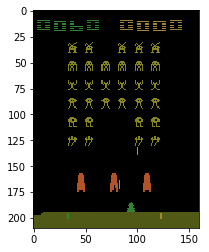

In [0]:
from IPython import display
env = gym.make('SpaceInvaders-ram-v0')
policy.load_state_dict(torch.load('pg_params.pkl'))
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(100000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()